In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

In [2]:
import sys
import os
sys.path.append("../../")

In [3]:
from axion_kSZ_source.auxiliary.helper_functions import is_array

In [4]:
r_vals = np.arange(20.0, 180.0, 2.0)
filter="sharpK"
diff = "5point"
m_a=5e-27

In [5]:
derivs_log = np.load(f"/scratch/r/rbond/gfarren/axion_kSZ/fisher_outputs/{filter}_filter_{diff}_rule_log_f/{filter}_{diff}_test_derivs_ma={m_a:.3E}.npy")
derivs = np.load(f"/scratch/r/rbond/gfarren/axion_kSZ/fisher_outputs/{filter}_filter_{diff}_rule/{filter}_{diff}_test_derivs_ma={m_a:.3E}.npy")

In [6]:
derivs.shape

(36, 10, 5, 80)

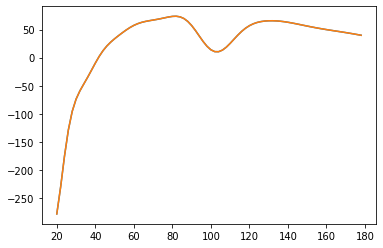

In [7]:
plt.plot(r_vals, derivs[0,0,0,:])
plt.plot(r_vals, derivs_log[0,0,0,:])

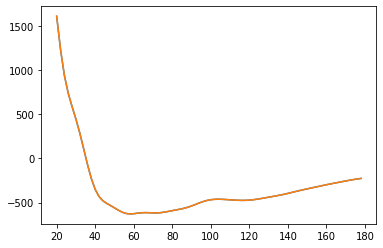

In [8]:
plt.plot(r_vals, derivs[0,1,0,:])
plt.plot(r_vals, derivs_log[0,1,0,:])

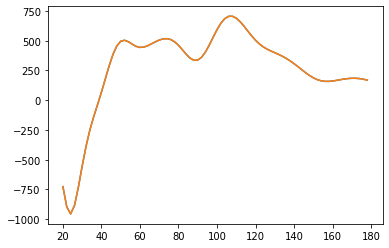

In [9]:
plt.plot(r_vals, derivs[0,2,0,:])
plt.plot(r_vals, derivs_log[0,2,0,:])

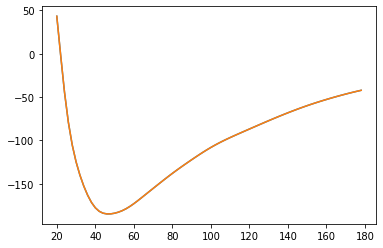

In [10]:
plt.plot(r_vals, derivs[0,3,0,:])
plt.plot(r_vals, derivs_log[0,3,0,:])

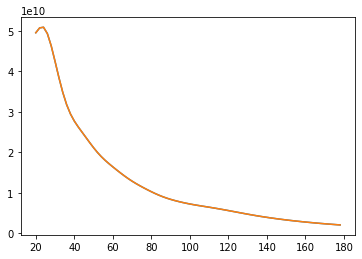

In [11]:
plt.plot(r_vals, derivs[0,4,0,:])
plt.plot(r_vals, derivs_log[0,4,0,:])

In [12]:
fisher_log = np.load(f"/scratch/r/rbond/gfarren/axion_kSZ/fisher_outputs/{filter}_filter_{diff}_rule_log_f/{filter}_{diff}_test_fisher_matrices_ma={m_a:.3E}.npy", allow_pickle=True)
fisher = np.load(f"/scratch/r/rbond/gfarren/axion_kSZ/fisher_outputs/{filter}_filter_{diff}_rule/{filter}_{diff}_test_fisher_matrices_ma={m_a:.3E}.npy", allow_pickle=True)

In [13]:
axion_abundances = np.array([1.0e-04, 1.6e-04, 2.5e-04, 4.0e-04, 6.3e-04, 1.0e-03, 1.6e-03, 2.5e-03, 4.0e-03, 6.3e-03, 1.0e-02, 1.6e-02, 2.5e-02, 4.0e-02, 5.3e-02, 6.3e-02, 1.0e-01, 1.1e-01, 1.6e-01, 2.1e-01, 2.5e-01, 2.6e-01, 3.2e-01, 3.7e-01, 4.0e-01, 4.2e-01, 4.7e-01, 5.3e-01, 5.8e-01, 6.3e-01, 6.8e-01, 7.4e-01, 7.9e-01, 8.4e-01, 8.9e-01, 9.5e-01])
fractional_step_sizes = np.array([0.05, 0.1, 0.2, 0.4])

0 -56.22751162800909
1 nan
2 nan
3 nan


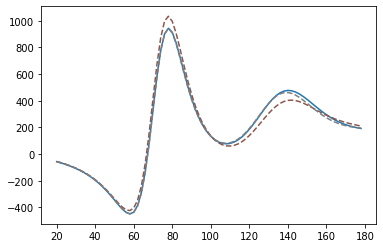

In [14]:
m_i=-3
z_i=4
for i in range(len(fractional_step_sizes)):
    print(i, derivs[m_i,5+i,z_i,0])
    plt.plot(r_vals, derivs[m_i,5+i,z_i,:])
    plt.plot(r_vals, derivs_log[m_i,5+i,z_i,:]/axion_abundances[m_i], linestyle="dashed")

In [15]:
np.exp(np.log(axion_abundances[20])*(1+np.array([-2,-1,0,1,2])*0.2))

array([0.43527528, 0.32987698, 0.25      , 0.18946457, 0.14358729])

In [16]:
np.log(1e-6)

-13.815510557964274

In [17]:
axion_constraints_log = np.full((len(axion_abundances), len(fractional_step_sizes)), np.nan)
axion_constraints = np.full((len(axion_abundances), len(fractional_step_sizes)), np.nan)

In [18]:
for i,frac in enumerate(axion_abundances):
    for j in range(len(fractional_step_sizes)):
        fisher_matrix =  np.copy(fisher_log[len(fractional_step_sizes)*i+j])
        fisher_matrix[:,5]/=axion_abundances[i]
        fisher_matrix[5,:]/=axion_abundances[i]
        axion_constraints_log[i,j] = np.sqrt(np.linalg.inv(fisher_matrix).diagonal()[5])
        axion_constraints[i,j] = np.sqrt(np.linalg.inv(fisher[len(fractional_step_sizes)*i+j]).diagonal()[5])

<ipython-input-19-e6810356072e>:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0.0, 1.5)


(0.0006710436473531049, 1.5)

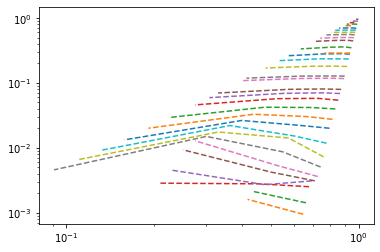

In [19]:
for i,frac in enumerate(axion_abundances):
    p=plt.plot(np.exp(fractional_step_sizes*np.log(frac)), frac+2*axion_constraints_log[i], linestyle="dashed")
    #plt.plot(fractional_step_sizes*frac, frac+2*axion_constraints[i], color=p[0].get_color())
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.0, 1.5)


<ipython-input-33-6b9dcf90db37>:1: RuntimeWarning: All-NaN slice encountered
  plt.errorbar(axion_abundances, axion_abundances, yerr=2*np.nanmax(axion_constraints_log, axis=-1), fmt="x")
<ipython-input-33-6b9dcf90db37>:2: RuntimeWarning: All-NaN slice encountered
  plt.errorbar(axion_abundances, axion_abundances, yerr=2*np.nanmax(axion_constraints, axis=-1), fmt="x")
<ipython-input-33-6b9dcf90db37>:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0.0,2.0)


(6.323272513470019e-05, 2.0)

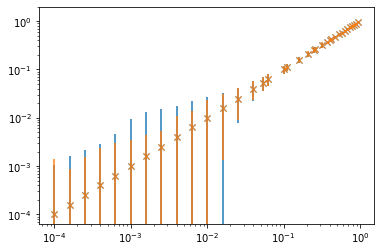

In [33]:
plt.errorbar(axion_abundances, axion_abundances, yerr=2*np.nanmax(axion_constraints_log, axis=-1), fmt="x")
plt.errorbar(axion_abundances, axion_abundances, yerr=2*np.nanmax(axion_constraints, axis=-1), fmt="x")
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.0,2.0)

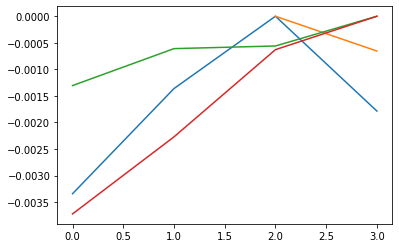

In [31]:
for i in range(len(axion_abundances)-4, len(axion_abundances), 1):
    plt.plot((axion_constraints_log[i,:]-np.nanmax(axion_constraints_log[i,:]))/(2*np.nanmax(axion_constraints_log[i,:])+axion_abundances[i]))

In [32]:
np.log(1e-5)

-11.512925464970229

In [21]:
axion_constraints_log[-1]

array([0.00021055, 0.0016003 , 0.00317322, 0.00377562])

In [29]:
np.exp((1+np.array([-2,-1,0,1,2])*0.45)*np.log(axion_abundances[-1]))

array([0.9948838 , 0.97218291, 0.95      , 0.92832325, 0.90714111])